In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from dateutil.relativedelta import relativedelta as rd

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import extract

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

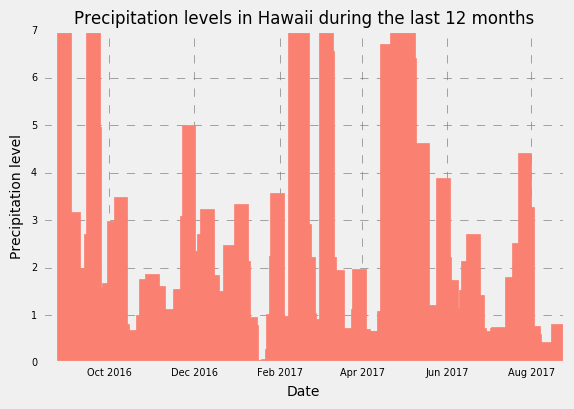

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
mostrecent = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
mostrecent = str(mostrecent)
mostrecent = dt.datetime.strptime(mostrecent, "('%Y-%m-%d',)")
backdate = mostrecent + rd(months=-12)

# Perform a query to retrieve the data and precipitation scores
prcp_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= backdate).order_by(Measurement.date.desc()).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(prcp_data, columns=['Date', 'prcp'])
df.set_index('Date', inplace=True, )

# Sort the dataframe by date
df.sort_index(inplace = True, ascending = True)

# Use Pandas Plotting with Matplotlib to plot the data

df_sum = df.groupby(level=0).sum()

x = df_sum.index.tolist()
y = df_sum['prcp'].tolist()

ax = plt.subplot(111) 
ax.xaxis_date()   
ax.bar(x, y, width=10, color='salmon', edgecolor='salmon')  

minx = dt.datetime.strptime(str(min(x)), "%Y-%m-%d") + rd(days=-10)
maxx = dt.datetime.strptime(str(max(x)), "%Y-%m-%d") + rd(days=+2)
plt.axis([minx, maxx, 0, 7])
ax.tick_params(direction='out', labelsize=7)
plt.title('Precipitation levels in Hawaii during the last 12 months', fontsize = 12)
plt.xlabel('Date', fontsize=10)
plt.ylabel('Precipitation level', fontsize=10)
ax.grid(color='gray', linestyle='--', linewidth=0.5)

plt.show()

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df_clean= df.dropna()
df_clean.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [12]:
# Design a query to show how many stations are available in this dataset?
st_number = session.query(Station.station).distinct().count()
print(st_number)


9


In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
st_names = session.query(Station.station).distinct().all()
st_list = []
for i in range(st_number):
    st_name_clean = str(st_names[i]).replace("('", "")
    st_name_clean = st_name_clean.replace("',)", "")
    rownumber = session.query(Measurement.station).filter(Measurement.station== st_name_clean).count()
    st_list.append((st_name_clean, rownumber))
st_list = sorted(st_list, key = lambda x: x[1], reverse = True) 
print(st_list)
    

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active = st_list[0]
most_active = most_active[0] #How to do this in a single line?

min_temp = list(session.query(Measurement).filter(Measurement.station == most_active).values(func.min(Measurement.tobs)))
max_temp = list(session.query(Measurement).filter(Measurement.station == most_active).values(func.max(Measurement.tobs)))
avg_temp = list(session.query(Measurement).filter(Measurement.station == most_active).values(func.avg(Measurement.tobs)))

most_active_pmts = [min_temp, max_temp, avg_temp]

print(most_active_pmts) #Why it looks like this with so many parenthesis?


[[(54.0,)], [(85.0,)], [(71.66378066378067,)]]


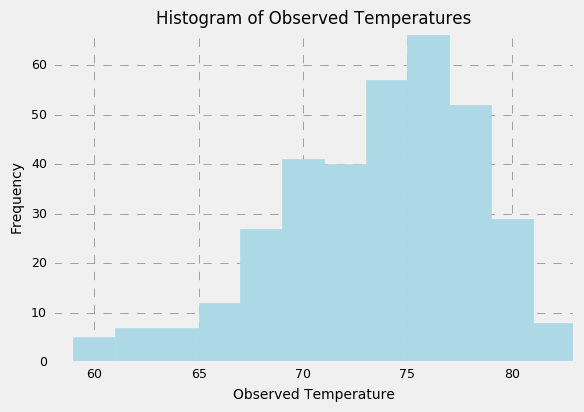

In [90]:
# Choose the station with the highest number of temperature observations.
tobs_data = session.query(Measurement.station, Measurement.date, Measurement.tobs).all()
df2 = pd.DataFrame(tobs_data, columns=['Station', 'Date', 'tobs'])
df2_clean = df2.dropna()
st_temps = df2_clean.groupby(['Station']).count()
st_temps = st_temps.sort_values(by='tobs', ascending=False)
st_max_tem = st_temps.first_valid_index()

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_data = session.query(Measurement.tobs).\
    filter(Measurement.station == st_max_tem, Measurement.date >= backdate).order_by(Measurement.date.desc()).all()
    
tobs_number = session.query(Measurement.tobs).\
    filter(Measurement.station == st_max_tem, Measurement.date >= backdate).order_by(Measurement.date.desc()).count()

tobs_list = []

for j in range(tobs_number):
    tobs_data_clean = str(tobs_data[j]).replace("(", "")
    tobs_data_clean = tobs_data_clean.replace(",)", "")
    tobs_list.append(float(tobs_data_clean))

#The histogram of the data
n, bins, patches = plt.hist(x=tobs_list, bins= 12, color='lightblue', edgecolor = 'lightblue', rwidth=2.5)

plt.axis([58, 83, 0, 67])
ax = plt.subplot(111)   
plt.xlabel('Observed Temperature', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
ax.tick_params(direction='out', labelsize=9)
plt.title('Histogram of Observed Temperatures', fontsize = 12)
plt.grid(True, color = 'gray', linestyle='--', linewidth=0.5)
plt.show()



In [115]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    start_date = dt.datetime.strptime(start_date, "%Y-%m-%d")
    end_date = dt.datetime.strptime(end_date, "%Y-%m-%d")
    
# Perform a query to retrieve the data and precipitation scores
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05')) #One value is different, don't know why...

[(62.0, 69.4375, 74.0)]


In [126]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
results = calc_temps('2011-02-28', '2011-03-05')
results = str(results).replace("[(", "")
results = str(results).replace(")]", "")
results_data = results.split(",")
results_clean = []
for result in results_data:
    results_clean.append(float(result))
print(results_clean)


[61.0, 69.775, 74.0]


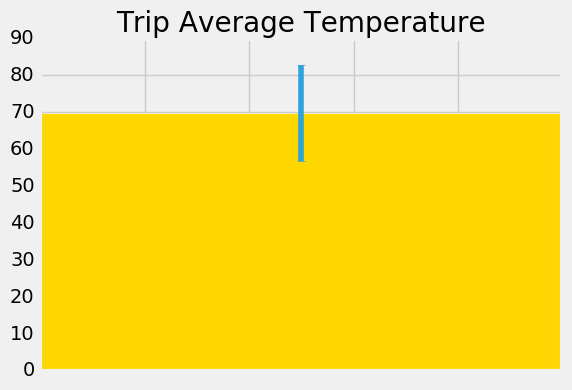

In [155]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

y = results_clean[1]
x = 0
peak_delta = results_clean[2]-results_clean[0]

fig, ax = plt.subplots()
graph= ax.bar(x, y, color='gold', width=0.5, yerr=peak_delta)
plt.title('Trip Average Temperature')
ax.set_xticklabels(labels='', fontdict={'horizontalalignment': 'center'})

plt.show()



In [172]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

start_date='2011-02-28'
end_date = '2011-03-05'

rainfall_data = session.query(Measurement.station,Measurement.date, Measurement.prcp,Station.name,Station.latitude,
                              Station.longitude, Station.elevation).\
    filter(Measurement.date >= '2016-06-06').filter(Measurement.date <= '2016-26-06').\
    filter(Measurement.station == Station.station).\
    order_by(Measurement.prcp.desc()).all()

final_data = []

print(rainfall_data[1])

#for k in range(st_number):
 #   if
    





('USC00513117', '2016-07-25', 7.65, 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6)


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


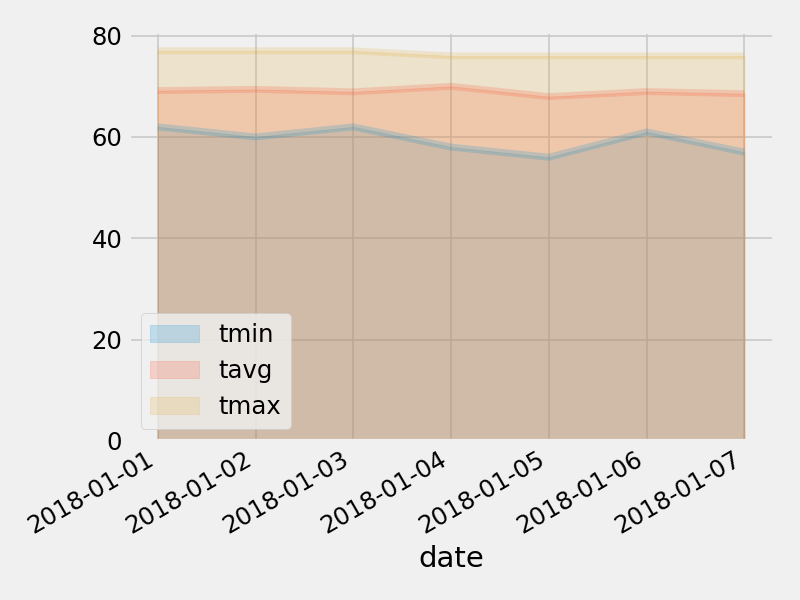

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
